In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
!pip install lime

     |████████████████████████████████| 276kB 4.6MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-cp36-none-any.whl size=283845 sha256=d7ab96e8fb9c2ab3ac0be37352351c7909a8e1ac9f2e032edff470dd1cd7d8b4
  Stored in directory: /root/.cache/pip/wheels/4c/4f/a5/0bc765457bd41378bf3ce8d17d7495369d6e7ca3b712c60c89
Successfully built lime


In [3]:
import torch
import torch.nn as nn
from torchvision import models
from torchvision import datasets
import torchvision.transforms as T
import matplotlib.pyplot as plt
import random
from lime import lime_image
import torch.nn.functional as F
import os
import json
from PIL import Image
import numpy as np
from skimage.segmentation import mark_boundaries

In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [5]:
def get_model(model_string):
    if model_string == 'resnet50':
        model = models.resnet50(pretrained = True)
    elif model_string == 'mobilenet':
        model = models.mobilenet_v2(pretrained = True)
    else: # default alexnet
        model =  models.alexnet(pretraiend = True)
    return model.to(device).eval()

In [6]:
model = get_model('mobilenet')

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


In [12]:
from google.colab import files
uploaded = files.upload()

Saving train_image.zip to train_image.zip


In [13]:
!mkdir /content/data
!unzip /content/train_image.zip -d /content/data

Archive:  /content/train_image.zip
   creating: /content/data/n01440764/
  inflating: /content/data/n01440764/ILSVRC2012_val_00009346.JPEG  
  inflating: /content/data/n01440764/ILSVRC2012_val_00011233.JPEG  
  inflating: /content/data/n01440764/ILSVRC2012_val_00003014.JPEG  
  inflating: /content/data/n01440764/ILSVRC2012_val_00006697.JPEG  
  inflating: /content/data/n01440764/ILSVRC2012_val_00000293.JPEG  
  inflating: /content/data/n01440764/ILSVRC2012_val_00009379.JPEG  
  inflating: /content/data/n01440764/ILSVRC2012_val_00010306.JPEG  
  inflating: /content/data/n01440764/ILSVRC2012_val_00009396.JPEG  
  inflating: /content/data/n01440764/ILSVRC2012_val_00007197.JPEG  
  inflating: /content/data/n01440764/ILSVRC2012_val_00002138.JPEG  
   creating: /content/data/n02102040/
  inflating: /content/data/n02102040/n02102040_1004.JPEG  
  inflating: /content/data/n02102040/n02102040_1003.JPEG  
  inflating: /content/data/n02102040/n02102040_1019.JPEG  
  inflating: /content/data/n0210

In [14]:
def get_dataset(dataset_string, transforms = None):
    if dataset_string.lower() == 'imagenet':
        dataset = datasets.ImageFolder(root='/content/data/', transform = transforms)
    else: # default CIFAR100
        dataset = datasets.CIFAR100('/data/cifar100', download = True, transform = transforms)
    return dataset

In [15]:
size = 224
dataset_notransform = get_dataset('imagenet')

dataset = get_dataset('imagenet', transforms=T.Compose([
            T.Resize((size,size)),
            T.ToTensor(),
            T.Normalize(mean=[0.485, 0.456, 0.406],
                                        std=[0.229, 0.224, 0.225])
            ]))

In [16]:
# Preprocess the image
def preprocess(image, size=224):
    transform = T.Compose([
        T.Resize((size,size)),
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        T.Lambda(lambda x: x[None]),
    ])
    return transform(image)

In [17]:
def deprocess(image):
    transform = T.Compose([
        T.Lambda(lambda x: x[0]),
        T.Normalize(mean=[0, 0, 0], std=[4.3668, 4.4643, 4.4444]),
        T.Normalize(mean=[-0.485, -0.456, -0.406], std=[1, 1, 1]),
        T.ToPILImage(),
    ])
    return transform(image)

In [18]:
def compute_activation_map(img):
    # preprocess the image
    X = img.to(device)
    # we need to find the gradient with respect to the input image, so we need to call requires_grad_ on it
    X.requires_grad_()
    '''
    forward pass through the model to get the scores
    '''
    scores = model(X)

    # Get the index corresponding to the maximum score and the maximum score itself.
    score_max_index = scores.argmax()
    score_max = scores[0,score_max_index]
    
    '''
    backward function on score_max performs the backward pass in the computation graph and calculates the gradient of 
    score_max with respect to nodes in the computation graph
    '''
    score_max.backward()
    '''
    Saliency would be the gradient with respect to the input image now. But note that the input image has 3 channels,
    R, G and B. To derive a single class saliency value for each pixel (i, j),  we take the maximum magnitude
    across all colour channels.
    '''
    saliency, _ = torch.max(X.grad.data.abs(),dim=1)
    saliency = saliency.cpu()
    X = X.cpu()
    return saliency, X

In [19]:
def lime(img):
    preprocess_transf = T.Compose([
            T.ToTensor(),
            T.Normalize(mean=[0.485, 0.456, 0.406],
                                        std=[0.229, 0.224, 0.225])
        ])  
    def batch_predict(images):
        batch = torch.stack(tuple(preprocess_transf(i) for i in images), dim=0)

        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model.to(device)
        batch = batch.to(device)

        logits = model(batch)
        probs = F.softmax(logits, dim=1)
        return probs.detach().cpu().numpy()
    explainer = lime_image.LimeImageExplainer()
    pill_transf = T.Compose([
            T.Resize((256, 256)),
            T.CenterCrop(224)
        ])
    explanation = explainer.explain_instance(np.array(pill_transf(img)), 
                                             batch_predict, # classification function
                                             top_labels=5, 
                                             hide_color=0, 
                                             num_samples=1000) # number of images that will be sent to classification function
    
    temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=5, hide_rest=False)
    return mark_boundaries(temp/255.0, mask)

In [20]:
idx2label, cls2label, cls2idx = [], {}, {}
with open(os.path.abspath('/content/imagenet_class_index.json'), 'r') as read_file:
    class_idx = json.load(read_file)
    idx2label = [class_idx[str(k)][1] for k in range(len(class_idx))]
    cls2label = {class_idx[str(k)][0]: class_idx[str(k)][1] for k in range(len(class_idx))}
    cls2idx = {class_idx[str(k)][0]: k for k in range(len(class_idx))}

In [21]:
def get_predictions(img, topk = 5):
    logits = model(img.to(device)).cpu()
    probs = F.softmax(logits, dim=1)
    probs_top = probs.topk(topk)
    return tuple((p, idx2label[c]) for p, c in zip(probs_top[0][0].detach().numpy(), 
                                                     probs_top[1][0].detach().numpy()))

In [88]:
def show_saliency(img, saliency_maps, titles, figtitle):
    fig, axes = plt.subplots(1,len(saliency_maps)+1, figsize = (20,5))
    axes[0].imshow(deprocess(img))
    axes[0].axis('off')
    axes[0].set_title('original')
    for i in range(1,len(axes)):
        if 'activation' in titles[i-1]:
            axes[i].imshow(saliency_maps[i-1], cmap=plt.cm.hot)
        else:
             axes[i].imshow(saliency_maps[i-1])
        axes[i].axis('off')
        axes[i].set_title(titles[i-1])
    fig.suptitle(figtitle, fontsize=16)

In [23]:
def get_idx(index):
    return dataset.imgs[index][0].split('/')[-2]

def get_class_str_label(index):
    return cls2label[get_idx(index)]

def get_class_int_label(index):
    return cls2idx[get_idx(index)]

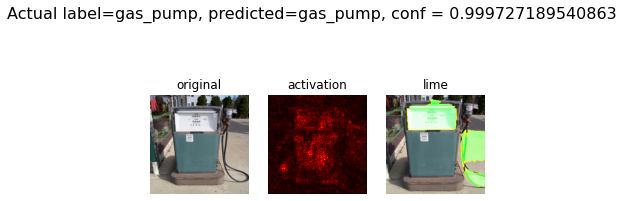

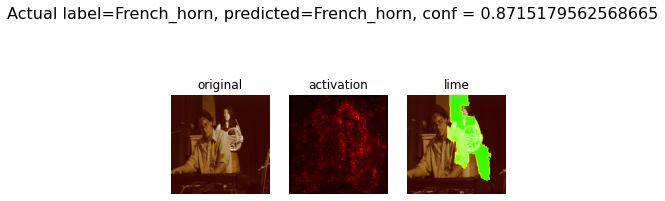

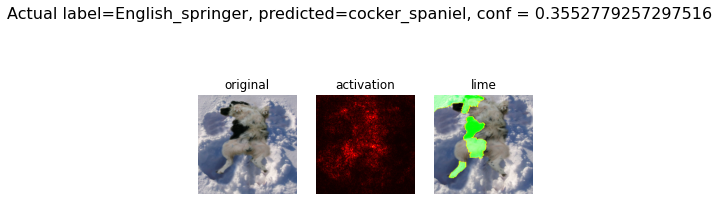

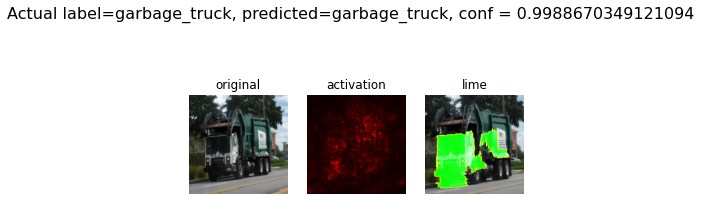

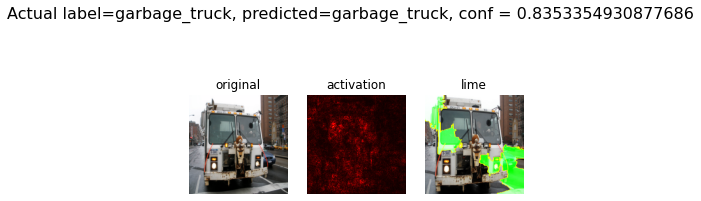

In [24]:
for i in random.sample(range(0, len(dataset)), 5):
    class_label = get_class_str_label(i)
    img = dataset[i][0].unsqueeze(0)
    conf,predicted_label = get_predictions(img, topk = 1)[0]
    activation,X = compute_activation_map(img)
    figtitle = "Actual label={}, predicted={}, conf = {}".format(class_label,
                                                           predicted_label,
                                                           conf)
    lime_img = lime(dataset_notransform[i][0])
    show_saliency(X,[activation[0],lime_img], ['activation','lime'], figtitle)

In [90]:
# FGSM attack code from https://pytorch.org/tutorials/beginner/fgsm_tutorial.html
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Return the perturbed image
    return perturbed_image, epsilon*sign_data_grad

In [91]:
def run_fgsm_attack(data, target, model, epsilon, device):
  # Send the data and label to the device
        data, target = data.to(device), target.to(device)

        # Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True

        # Forward pass the data through the model
        output = model(data)
        _,init_pred = F.softmax(output, dim=1).topk(1)
        #init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability

        # If the initial prediction is wrong, dont bother attacking, just move on
        #if init_pred != target.item():
        #    return data,init_pred

        # Calculate the loss
        loss = F.nll_loss(output, target)

        # Zero all existing gradients
        model.zero_grad()

        # Calculate gradients of model in backward pass
        loss.backward()

        # Collect datagrad
        data_grad = data.grad.data

        # Call FGSM Attack
        perturbed_data, noise = fgsm_attack(data, epsilon, data_grad)
        return perturbed_data, init_pred, noise

In [92]:
def test( model, device, test_loader, epsilon ):
    # Accuracy counter
    correct = 0
    init_correct = 0
    adv_examples = []

    # Loop over all examples in test set
    for i,(data, _) in enumerate(test_loader):

        target_int = get_class_int_label(i)
        target = torch.Tensor([target_int]).type(torch.int64)
        
        perturbed_data, init_pred,_ = run_fgsm_attack(data, target, model, 
                                                    epsilon, device)

        if init_pred == target.item():
          init_correct += 1

        # Re-classify the perturbed image
        output = model(perturbed_data)

        # Check for success
        #final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        _,final_pred = F.softmax(output, dim=1).topk(1)
        if final_pred == target.item():
            correct += 1
            # Special case for saving 0 epsilon examples
            if (epsilon == 0) and (len(adv_examples) < 5):
                adv_ex = perturbed_data.squeeze().detach().cpu()#.numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        else:
            # Save some adv examples for visualization later
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu()#.numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_loader))
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}, initial {}".format(epsilon, correct, len(test_loader), final_acc,init_correct))

    # Return the accuracy and an adversarial example
    return final_acc, adv_examples

In [32]:
accuracies = []
examples = []
device = torch.device("cuda" if (torch.cuda.is_available()) else "cpu")

size = 224
test_loader = torch.utils.data.DataLoader(
    dataset = dataset,
    batch_size=1, shuffle=False)

def predict():
    num_correct = 0
    for i, (data,_) in enumerate(test_loader):
        logits = model(data.to(device))
        p,v = F.softmax(logits, dim=1).topk(1)
        if v == get_class_int_label(i):
          num_correct+=1
    print(num_correct)

# Run test for each epsilon
epsilons = [0, .05, .1, .15, .2, .25, .3]
for eps in epsilons:
    acc, ex = test(model, device, test_loader, eps)
    accuracies.append(acc)
    examples.append(ex)

Epsilon: 0	Test Accuracy = 70 / 100 = 0.7, initial 70
Epsilon: 0.05	Test Accuracy = 6 / 100 = 0.06, initial 70
Epsilon: 0.1	Test Accuracy = 5 / 100 = 0.05, initial 70
Epsilon: 0.15	Test Accuracy = 5 / 100 = 0.05, initial 70
Epsilon: 0.2	Test Accuracy = 7 / 100 = 0.07, initial 70
Epsilon: 0.25	Test Accuracy = 6 / 100 = 0.06, initial 70
Epsilon: 0.3	Test Accuracy = 3 / 100 = 0.03, initial 70


In [29]:
# Plot several examples of adversarial samples at each epsilon
cnt = 0
plt.figure(figsize=(20,20))
for i in range(len(epsilons)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(examples[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
        orig,adv,ex = examples[i][j]
        plt.title("{} -> {}".format(idx2label[orig], idx2label[adv]))
        plt.imshow(deprocess(ex.unsqueeze(0)))#ex.transpose(1,2,0))
plt.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.

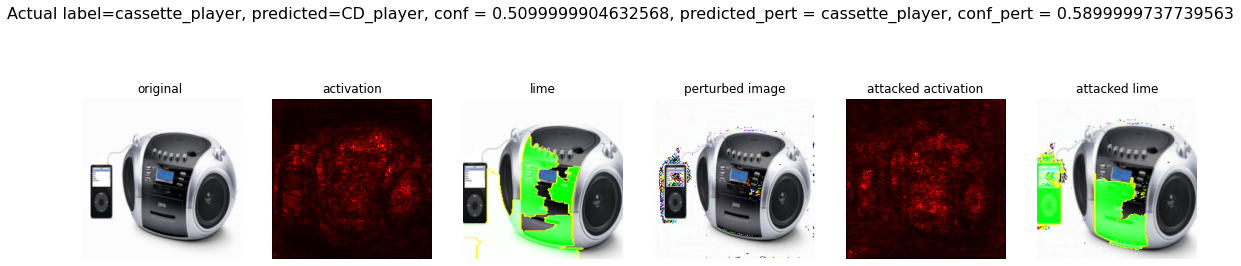

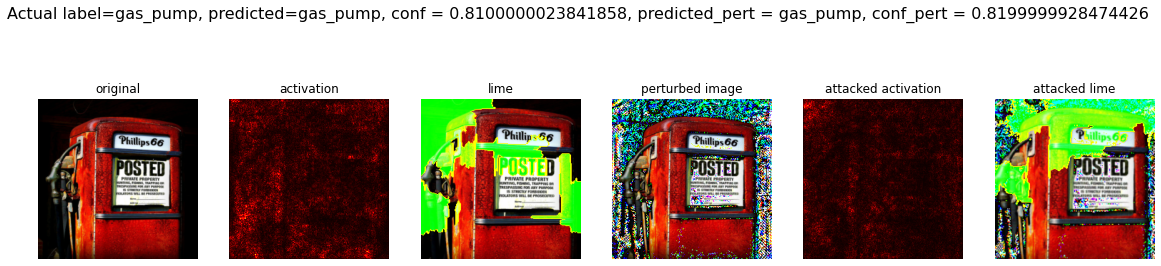

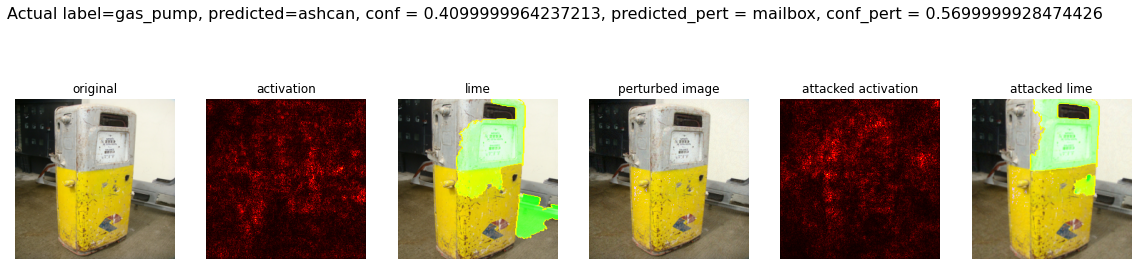

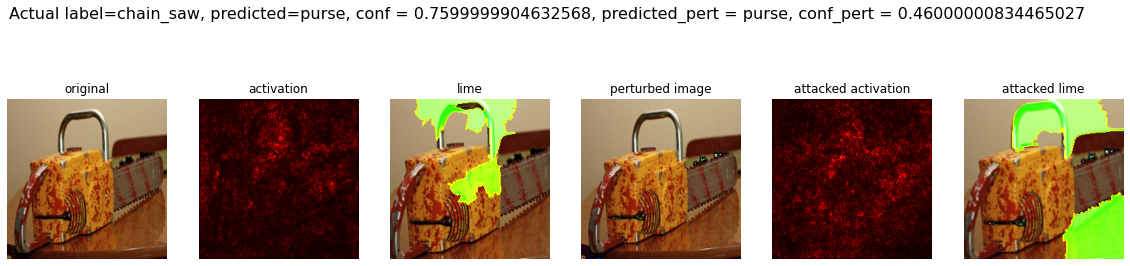

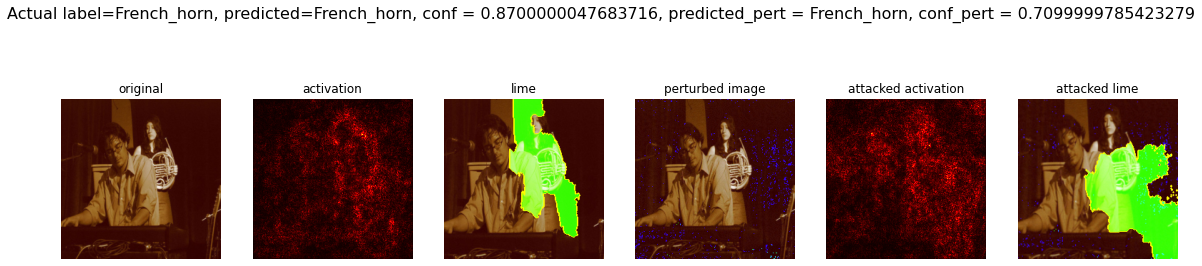

In [107]:
epsilon = 0.05
for i in random.sample(range(0, len(dataset)), 5):
    class_label = get_class_str_label(i)
    img = dataset[i][0].unsqueeze(0)
    target_int = get_class_int_label(j)
    target = torch.Tensor([target_int]).type(torch.int64)
    perturbed_data,_,noise = run_fgsm_attack(img, target, model, epsilon, device)
    perturbed_data = perturbed_data.detach().cpu()
    
    conf,predicted_label = get_predictions(img, topk = 1)[0]
    conf = conf.round(2)
    activation,X = compute_activation_map(img)
    lime_img = lime(dataset_notransform[i][0])
    
    conf_perturb,predicted_label_perturb = get_predictions(perturbed_data, topk = 1)[0]
    conf_perturb = conf_perturb.round(2)
    activation_perturb,X_perturb = compute_activation_map(perturbed_data)
    lime_img_perturb = lime(deprocess(perturbed_data))#dataset_notransform[i][0])

    figtitle = "Actual label={}, predicted={}, conf = {}, predicted_pert = {}, conf_pert = {}".format(class_label,
                                                           predicted_label,
                                                           conf,
                                                           predicted_label_perturb,
                                                           conf_perturb)
    
    show_saliency(X,[activation[0],lime_img,deprocess(X_perturb), activation_perturb[0], lime_img_perturb], ['activation','lime', 'perturbed image', 'attacked activation', 'attacked lime'], figtitle)

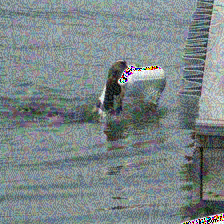

In [72]:
deprocess(perturbed_data)

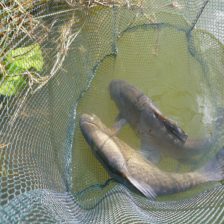

In [37]:
j = 0
deprocess(dataset[j])

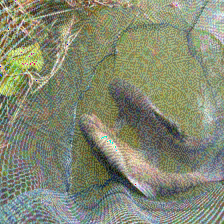

In [48]:
target_int = get_class_int_label(j)
target = torch.Tensor([target_int]).type(torch.int64)
perturbed_data,_ = run_fgsm_attack(dataset[j][0].unsqueeze(0), target, model, 0.3, device)
deprocess(perturbed_data.cpu())

In [53]:
type(lime_img)

numpy.ndarray